In [162]:
from pathlib import Path

import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr

import rioxarray

data_dir = Path("../data")
output_dir = data_dir / "outputs"
plots_dir = output_dir / "plots"
metrics_dir = plots_dir / "metrics" / "x1-y1-z1" / "net_cdf"

In [163]:
cover_and_limits = pd.read_csv(output_dir / "lidar_assessed_storey_limits.csv")
cover_and_limits = cover_and_limits.set_index('site_plot_id')
cover_and_limits = cover_and_limits.drop(columns=['comments'])
cover_and_limits = cover_and_limits.dropna(subset=['la_ground_limit'])
cover_and_limits = cover_and_limits.dropna(subset=['veg_ground_total', 'veg_understorey_total'], how='all')
cover_and_limits

,veg_ground_total,veg_understorey_total,veg_midstorey_total,veg_upperstorey_total,veg_total_cover_total,la_ground_limit,la_understorey_limit,la_midstorey_limit,confidence
site_plot_id,,,,,,,,,
AGG_O_01_P1,9.0,3.0,NaN,20.0,25.0,1.0,4.0,NaN,1.0
AGG_O_01_P2,6.0,3.0,NaN,9.0,15.0,1.0,4.0,NaN,1.0
AGG_O_01_P3,3.0,3.0,NaN,17.0,23.0,1.0,4.0,NaN,1.0
AGG_O_01_P4,9.0,18.0,19.0,2.0,42.0,1.0,10.0,30.0,0.8
AGG_O_01_P5,12.0,10.0,17.0,2.0,32.0,1.0,10.0,30.0,0.8
...,...,...,...,...,...,...,...,...,...
ULY_Y_96_P1,31.0,20.0,7.0,0.0,38.0,1.0,3.0,17.0,0.5
ULY_Y_96_P2,35.0,39.0,7.0,0.0,50.0,1.0,3.0,17.0,0.5
ULY_Y_96_P3,29.0,26.0,3.0,3.0,40.0,1.0,3.0,17.0,0.5


# TODO

Go through each row, read in each file and calculate the cover for that storey.

In [188]:
def get_cover(ds: xr.Dataset, lower: int, upper: int | None):
    ds_slice = ds.sel(z=slice(lower, upper))

    inside = ds_slice["vox_inside_count"]
    enter = ds_slice["vox_enter_count"].max(dim="z")

    cover_sum = (inside.sum().item()) / (enter.sum().item()) * 100
    cover_mean = (inside.sum(dim='z') / enter).mean().item() * 100

    inside_weight = ds_slice["vox_inside_weight"]
    enter_weight = ds_slice["vox_enter_weight"].max(dim="z")

    cover_sum_weight = (inside_weight.sum().item()) / (enter_weight.sum().item()) * 100
    cover_mean_weight = (inside_weight.sum(dim='z') / enter_weight).mean().item() * 100


    return (cover_sum, cover_mean, cover_sum_weight, cover_mean_weight)


In [189]:
def get_lidar_cover_metrics(
    site_plot_id: str, understorey_limit: int | None, midstorey_limit: int | None
):
    ds = xr.open_dataset(metrics_dir / f"{site_plot_id}.nc")
    ds.load()

    ground_lower = 1
    ground_upper = 1

    ground_cover_sum, ground_cover_mean, ground_cover_sum_weight, ground_cover_mean_weight = get_cover(ds, 1, 1)

    understorey_lower = ground_upper + 1
    understorey_upper = (
        understorey_limit if not pd.isna(understorey_limit) else (understorey_lower - 1)
    )

    midstorey_lower = understorey_upper + 1
    midstorey_upper = (
        midstorey_limit if not pd.isna(midstorey_limit) else (midstorey_lower - 1)
    )

    upperstorey_lower = midstorey_upper + 1
    upperstorey_upper = None

    understorey_cover_sum, understorey_cover_mean, understorey_cover_sum_weight, understorey_cover_mean_weight = (0, 0, 0, 0)
    midstorey_cover_sum, midstorey_cover_mean, midstorey_cover_sum_weight, midstorey_cover_mean_weight = (0, 0, 0, 0)
    upperstorey_cover_sum, upperstorey_cover_mean, upperstorey_cover_sum_weight, upperstorey_cover_mean_weight = (0, 0, 0, 0)

    if understorey_upper >= understorey_lower:
        understorey_cover_sum, understorey_cover_mean, understorey_cover_sum_weight, understorey_cover_mean_weight = get_cover(
            ds, understorey_lower, understorey_upper
        )

    if midstorey_upper >= midstorey_lower:
        midstorey_cover_sum, midstorey_cover_mean, midstorey_cover_sum_weight, midstorey_cover_mean_weight = get_cover(
            ds, midstorey_lower, midstorey_upper
        )

    # There's always an upperstorey
    if upperstorey_lower <= ds.z.max().item():
        upperstorey_cover_sum, upperstorey_cover_mean, upperstorey_cover_sum_weight, upperstorey_cover_mean_weight = get_cover(
            ds, upperstorey_lower, upperstorey_upper
        )

    ds.close()

    return pd.Series(
        [
            ground_cover_sum,
            ground_cover_mean,
            ground_cover_sum_weight,
            ground_cover_mean_weight,
            understorey_cover_sum,
            understorey_cover_mean,
            understorey_cover_sum_weight,
            understorey_cover_mean_weight,
            midstorey_cover_sum,
            midstorey_cover_mean,
            midstorey_cover_sum_weight,
            midstorey_cover_mean_weight,
            upperstorey_cover_sum,
            upperstorey_cover_mean,
            upperstorey_cover_sum_weight,
            upperstorey_cover_mean_weight,
        ]
    )


cover_and_limits[
    [
        "l_ground_cover_sum",
        "l_ground_cover_mean",
        "l_ground_cover_sum_weight",
        "l_ground_cover_mean_weight",
        "l_understorey_cover_sum",
        "l_understorey_cover_mean",
        "l_understorey_cover_sum_weight",
        "l_understorey_cover_mean_weight",
        "l_midstorey_cover_sum",
        "l_midstorey_cover_mean",
        "l_midstorey_cover_sum_weight",
        "l_midstorey_cover_mean_weight",
        "l_upperstorey_cover_sum",
        "l_upperstorey_cover_mean",
        "l_upperstorey_cover_sum_weight",
        "l_upperstorey_cover_mean_weight",
    ]
] = cover_and_limits.apply(
    lambda row: get_lidar_cover_metrics(
        row.name, row["la_understorey_limit"], row["la_midstorey_limit"]
    ),
    axis=1,
)


cover_and_limits

,veg_ground_total,veg_understorey_total,veg_midstorey_total,veg_upperstorey_total,veg_total_cover_total,la_ground_limit,la_understorey_limit,la_midstorey_limit,confidence,l_ground_cover_sum,...,l_upperstorey_cover_sum,l_upperstorey_cover_mean,l_ground_cover_sum_weight,l_ground_cover_mean_weight,l_understorey_cover_sum_weight,l_understorey_cover_mean_weight,l_midstorey_cover_sum_weight,l_midstorey_cover_mean_weight,l_upperstorey_cover_sum_weight,l_upperstorey_cover_mean_weight
site_plot_id,,,,,,,,,,,,,,,,,,,,,
AGG_O_01_P1,9.0,3.0,0.0,20.0,25.0,1.0,4.0,NaN,1.0,45.552402,...,52.057166,48.071065,45.232569,47.601193,13.487297,13.235867,0.000000,0.000000,50.882616,48.252944
AGG_O_01_P2,6.0,3.0,0.0,9.0,15.0,1.0,4.0,NaN,1.0,38.144138,...,52.894286,49.036484,35.704257,40.263256,14.607192,14.210006,0.000000,0.000000,52.245889,49.759959
AGG_O_01_P3,3.0,3.0,0.0,17.0,23.0,1.0,4.0,NaN,1.0,44.598803,...,55.914440,53.030133,44.839246,47.357775,19.392977,18.726996,0.000000,0.000000,56.051947,53.492825
AGG_O_01_P4,9.0,18.0,19.0,2.0,42.0,1.0,10.0,30.0,0.8,61.232958,...,22.770257,16.152732,62.856762,62.733297,60.922456,60.169925,33.106561,29.405346,22.293299,16.072162
AGG_O_01_P5,12.0,10.0,17.0,2.0,32.0,1.0,10.0,30.0,0.8,46.999976,...,25.062713,20.040979,48.997319,47.549081,56.995308,53.888520,50.281633,47.322764,26.167237,20.408356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ULY_Y_96_P1,31.0,20.0,7.0,0.0,38.0,1.0,3.0,17.0,0.5,69.196035,...,1.324859,1.000842,72.059883,62.903931,14.988095,18.124774,43.257148,39.186705,1.107570,0.914479
ULY_Y_96_P2,35.0,39.0,7.0,0.0,50.0,1.0,3.0,17.0,0.5,75.727018,...,6.451482,3.563321,76.658721,75.263325,16.011957,17.993120,19.298282,17.045596,4.911254,3.416992
ULY_Y_96_P3,29.0,26.0,3.0,3.0,40.0,1.0,3.0,17.0,0.5,79.282139,...,1.195014,0.659513,80.469356,79.879841,25.798112,26.677435,14.404995,12.287468,0.737877,0.495731


In [190]:
cover_and_limits[['veg_understorey_total', 'veg_midstorey_total', 'veg_upperstorey_total']] = (
    cover_and_limits[['veg_understorey_total', 'veg_midstorey_total', 'veg_upperstorey_total']].fillna(0)
)
cover_and_limits

,veg_ground_total,veg_understorey_total,veg_midstorey_total,veg_upperstorey_total,veg_total_cover_total,la_ground_limit,la_understorey_limit,la_midstorey_limit,confidence,l_ground_cover_sum,...,l_upperstorey_cover_sum,l_upperstorey_cover_mean,l_ground_cover_sum_weight,l_ground_cover_mean_weight,l_understorey_cover_sum_weight,l_understorey_cover_mean_weight,l_midstorey_cover_sum_weight,l_midstorey_cover_mean_weight,l_upperstorey_cover_sum_weight,l_upperstorey_cover_mean_weight
site_plot_id,,,,,,,,,,,,,,,,,,,,,
AGG_O_01_P1,9.0,3.0,0.0,20.0,25.0,1.0,4.0,NaN,1.0,45.552402,...,52.057166,48.071065,45.232569,47.601193,13.487297,13.235867,0.000000,0.000000,50.882616,48.252944
AGG_O_01_P2,6.0,3.0,0.0,9.0,15.0,1.0,4.0,NaN,1.0,38.144138,...,52.894286,49.036484,35.704257,40.263256,14.607192,14.210006,0.000000,0.000000,52.245889,49.759959
AGG_O_01_P3,3.0,3.0,0.0,17.0,23.0,1.0,4.0,NaN,1.0,44.598803,...,55.914440,53.030133,44.839246,47.357775,19.392977,18.726996,0.000000,0.000000,56.051947,53.492825
AGG_O_01_P4,9.0,18.0,19.0,2.0,42.0,1.0,10.0,30.0,0.8,61.232958,...,22.770257,16.152732,62.856762,62.733297,60.922456,60.169925,33.106561,29.405346,22.293299,16.072162
AGG_O_01_P5,12.0,10.0,17.0,2.0,32.0,1.0,10.0,30.0,0.8,46.999976,...,25.062713,20.040979,48.997319,47.549081,56.995308,53.888520,50.281633,47.322764,26.167237,20.408356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ULY_Y_96_P1,31.0,20.0,7.0,0.0,38.0,1.0,3.0,17.0,0.5,69.196035,...,1.324859,1.000842,72.059883,62.903931,14.988095,18.124774,43.257148,39.186705,1.107570,0.914479
ULY_Y_96_P2,35.0,39.0,7.0,0.0,50.0,1.0,3.0,17.0,0.5,75.727018,...,6.451482,3.563321,76.658721,75.263325,16.011957,17.993120,19.298282,17.045596,4.911254,3.416992
ULY_Y_96_P3,29.0,26.0,3.0,3.0,40.0,1.0,3.0,17.0,0.5,79.282139,...,1.195014,0.659513,80.469356,79.879841,25.798112,26.677435,14.404995,12.287468,0.737877,0.495731


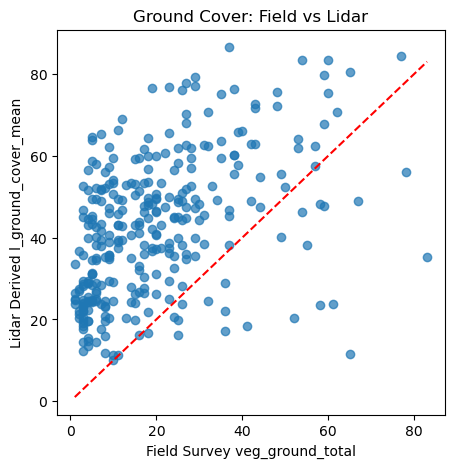

Ground - Correlation: 0.47, MAE: 25.00, RMSE: 28.42


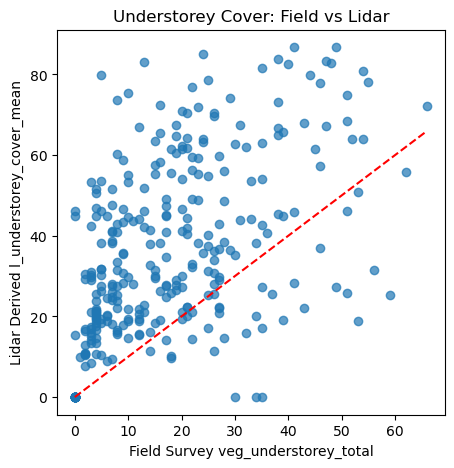

Understorey - Correlation: 0.51, MAE: 21.02, RMSE: 26.33


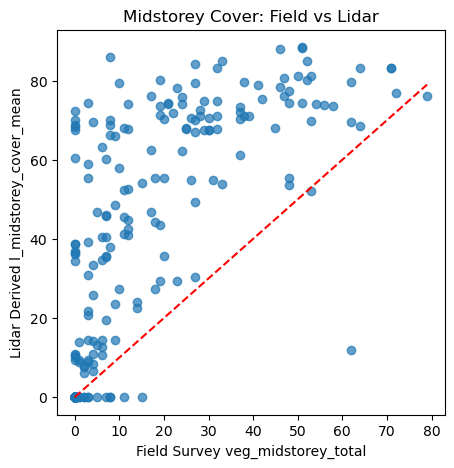

Midstorey - Correlation: 0.76, MAE: 17.59, RMSE: 27.52


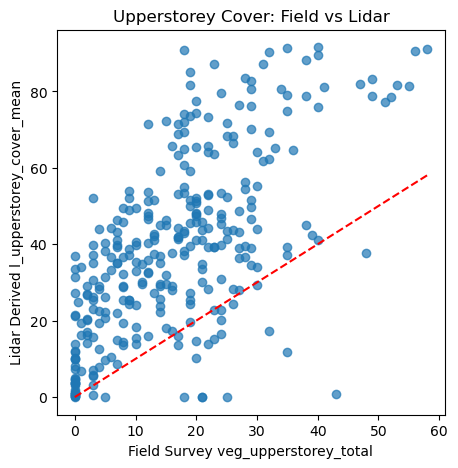

Upperstorey - Correlation: 0.65, MAE: 23.97, RMSE: 28.79


In [191]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
storeys = ['ground', 'understorey', 'midstorey', 'upperstorey']
for s in storeys:
    field = f'veg_{s}_total'
    lidar = f'l_{s}_cover_mean'
    if field in cover_and_limits.columns and lidar in cover_and_limits.columns:
        x = cover_and_limits[field]
        y = cover_and_limits[lidar]
        plt.figure(figsize=(5,5))
        plt.scatter(x, y, alpha=0.7)
        plt.xlabel(f'Field Survey {field}')
        plt.ylabel(f'Lidar Derived {lidar}')
        plt.title(f'{s.capitalize()} Cover: Field vs Lidar')
        plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')
        plt.show()
        corr = x.corr(y)
        mae = mean_absolute_error(x, y)
        rmse = mean_squared_error(x, y) ** 0.5
        print(f"{s.capitalize()} - Correlation: {corr:.2f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

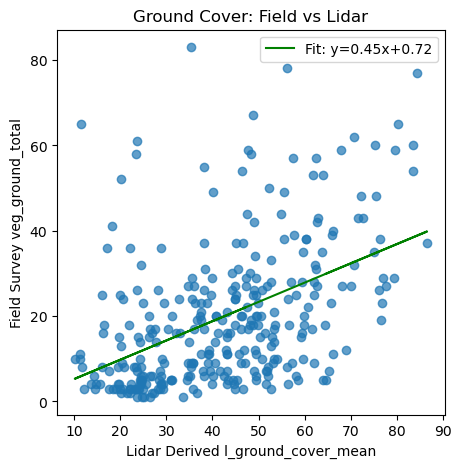

Ground - Linear fit: y = 0.45x + 0.72, R^2 = 0.22, P = 0.000


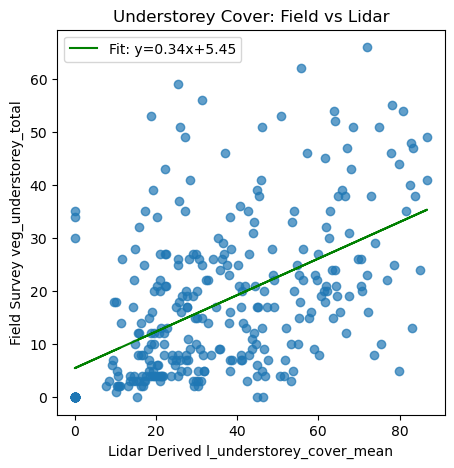

Understorey - Linear fit: y = 0.34x + 5.45, R^2 = 0.26, P = 0.000


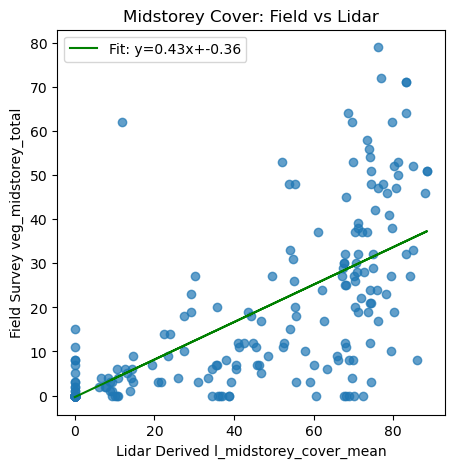

Midstorey - Linear fit: y = 0.43x + -0.36, R^2 = 0.58, P = 0.000


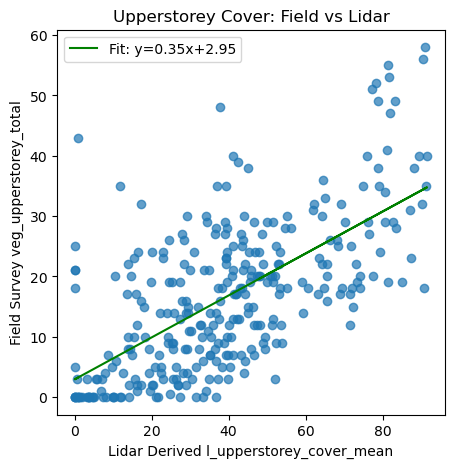

Upperstorey - Linear fit: y = 0.35x + 2.95, R^2 = 0.43, P = 0.000


In [192]:
from scipy.stats import linregress

for s in storeys:
    field = f'veg_{s}_total'
    lidar = f'l_{s}_cover_mean'
    if field in cover_and_limits.columns and lidar in cover_and_limits.columns:
        x = cover_and_limits[lidar]
        y = cover_and_limits[field]
        plt.figure(figsize=(5,5))
        plt.scatter(x, y, alpha=0.7)
        # Fit linear regression
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        plt.plot(x, slope*x + intercept, 'g-', label=f'Fit: y={slope:.2f}x+{intercept:.2f}')
        plt.xlabel(f'Lidar Derived {lidar}')
        plt.ylabel(f'Field Survey {field}')
        plt.title(f'{s.capitalize()} Cover: Field vs Lidar')
        plt.legend()
        plt.show()
        print(f"{s.capitalize()} - Linear fit: y = {slope:.2f}x + {intercept:.2f}, R^2 = {r_value**2:.2f}, P = {p_value:.3f}")

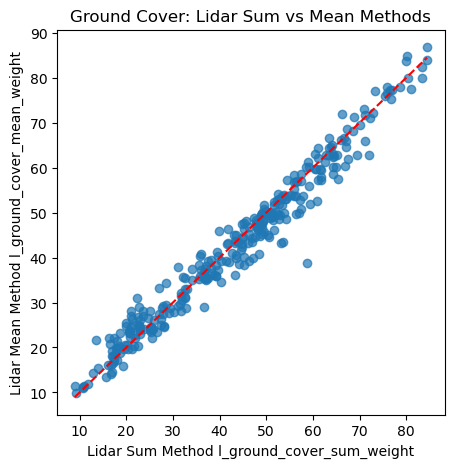

Ground - Correlation: 0.98, MAE: 2.47, RMSE: 3.38


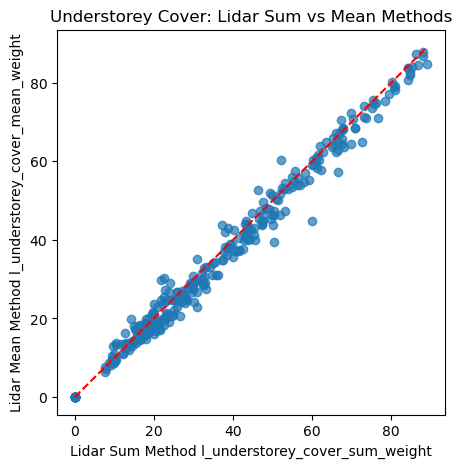

Understorey - Correlation: 0.99, MAE: 2.09, RMSE: 2.87


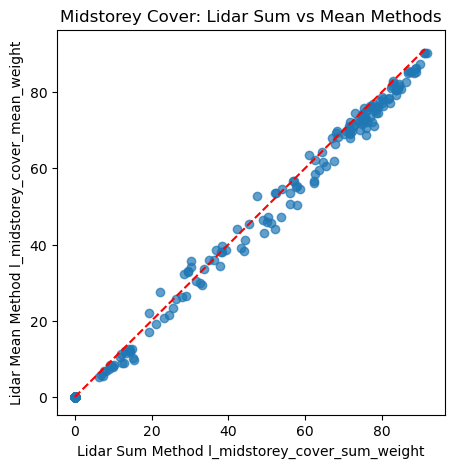

Midstorey - Correlation: 1.00, MAE: 1.36, RMSE: 2.24


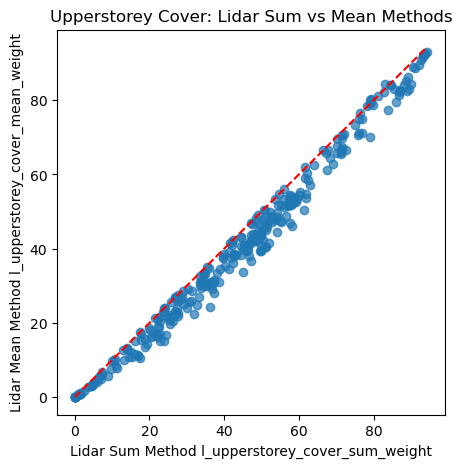

Upperstorey - Correlation: 0.99, MAE: 3.66, RMSE: 4.62


In [199]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
storeys = ['ground', 'understorey', 'midstorey', 'upperstorey']
for s in storeys:
    lidar_method_1 = f'l_{s}_cover_sum_weight'
    lidar_method_2 = f'l_{s}_cover_mean_weight'
    if lidar_method_1 in cover_and_limits.columns and lidar_method_2 in cover_and_limits.columns:
        x = cover_and_limits[lidar_method_1]
        y = cover_and_limits[lidar_method_2]
        plt.figure(figsize=(5,5))
        plt.scatter(x, y, alpha=0.7)
        plt.xlabel(f'Lidar Sum Method {lidar_method_1}')
        plt.ylabel(f'Lidar Mean Method {lidar_method_2}')
        plt.title(f'{s.capitalize()} Cover: Lidar Sum vs Mean Methods')
        plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')
        plt.show()
        corr = x.corr(y)
        mae = mean_absolute_error(x, y)
        rmse = mean_squared_error(x, y) ** 0.5
        print(f"{s.capitalize()} - Correlation: {corr:.2f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")